Library


In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

Load Data

In [240]:
# path
ticker_data = data = pd.read_csv('ticker_data_with_industry.csv', parse_dates=['time'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))


# get all ticker name
def ticker_name(data_ticker):
    return data_ticker['ticker'].unique().tolist()

# get data of a specific ticker
def take_data_ticker(data_ticker, name_ticker):
    for ticker in name_ticker:
        filtered_data = data_ticker[data_ticker['ticker'] == ticker]
    return filtered_data

ticker_name_lite = ['SSI']

data_lite = take_data_ticker(ticker_data, ticker_name_lite)


/tmp/ipykernel_1015/3735604464.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ticker_data = data = pd.read_csv('ticker_data_with_industry.csv', parse_dates=['time'], date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'))


MA


/tmp/ipykernel_1015/3126910408.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by='time', inplace=True)


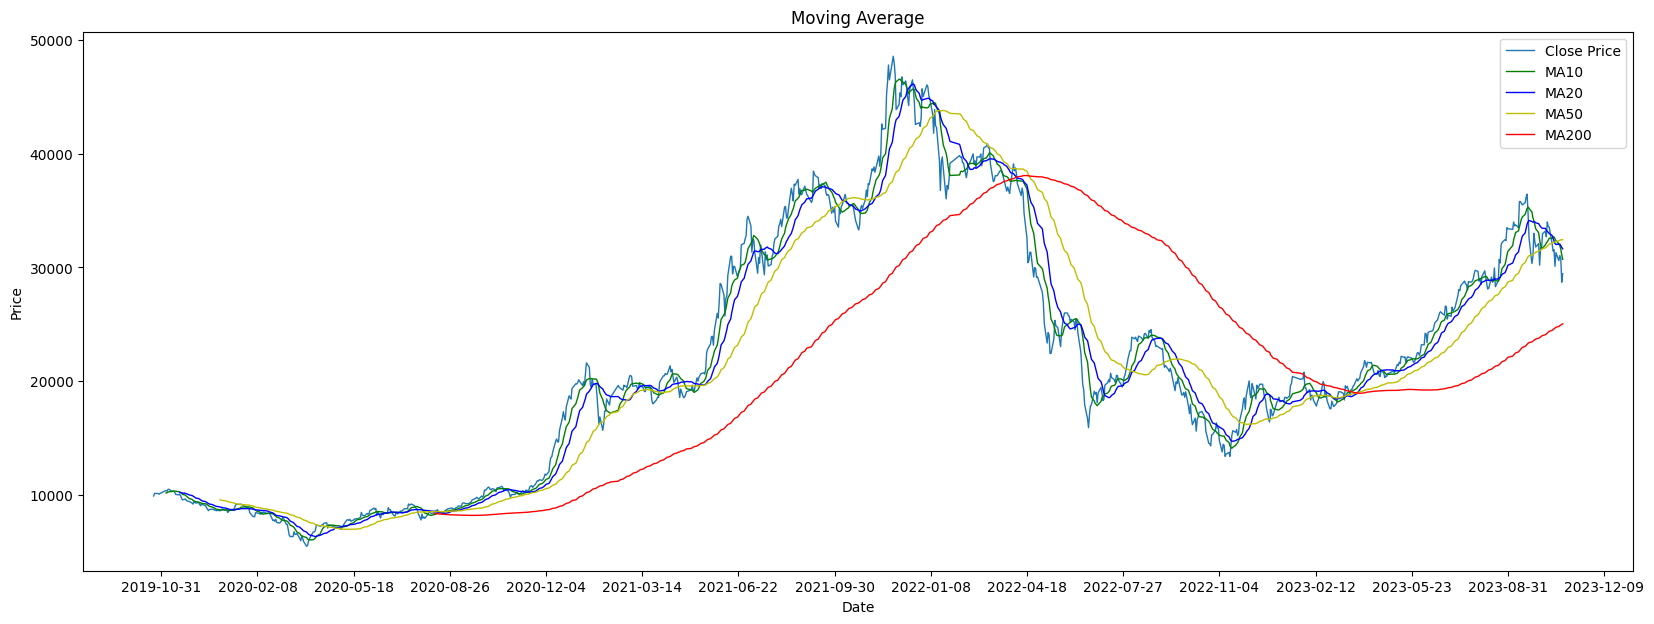

In [241]:
# Simple Moving Average 
def SMA(data, ndays): 
    sma_column_name = f'MA{ndays}'
    SMA = pd.Series(data['close'].rolling(ndays).mean(), name=sma_column_name) 
    data = data.join(SMA)
    return data 

# take data
data = data_lite
data.sort_values(by='time', inplace=True)

# Compute the 10-day EWMA
n1 = 10
data = SMA(data, n1)  

# Compute the 20-day EWMA
n2 = 20
data = SMA(data, n2)  

# Compute the 50-day SMA
n3 = 50
data = SMA(data, n3)  

# Compute the 200-day SMA
n4 = 200
data = SMA(data, n4)  

# Plot
fig, ax = plt.subplots(figsize=(20,7))
plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')

# Plot close price and moving averages
plt.plot(data['time'], data['close'], lw=1, label='Close Price')
plt.plot(data['time'], data['MA10'], 'g', lw=1, label='MA10')
plt.plot(data['time'], data['MA20'], 'b', lw=1, label='MA20')
plt.plot(data['time'], data['MA50'], 'y', lw=1, label='MA50')
plt.plot(data['time'], data['MA200'], 'r', lw=1, label='MA200')
ax.xaxis.set_major_locator(ticker.MaxNLocator(17))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Add a legend to the axis
plt.legend()
plt.show()


In [242]:
data.tail()

,time,open,high,low,close,volume,ticker,industry,MA10,MA20,MA50,MA200
1001,2023-10-23,30600,31350,30400,30600,15339400,SSI,Dịch vụ tài chính,32095.0,32039.95,32335.98,24801.245
1002,2023-10-24,31000,31150,30450,31050,14254500,SSI,Dịch vụ tài chính,31930.0,32047.45,32393.98,24865.595
1003,2023-10-25,31000,31550,30800,30800,14381400,SSI,Dịch vụ tài chính,31610.0,31937.45,32426.98,24928.195
1004,2023-10-26,29700,29950,28650,28700,54159900,SSI,Dịch vụ tài chính,31120.0,31757.50,32426.98,24978.845
1005,2023-10-27,29250,29800,28750,29450,20052100,SSI,Dịch vụ tài chính,30710.0,31640.00,32438.98,25035.195


RSI

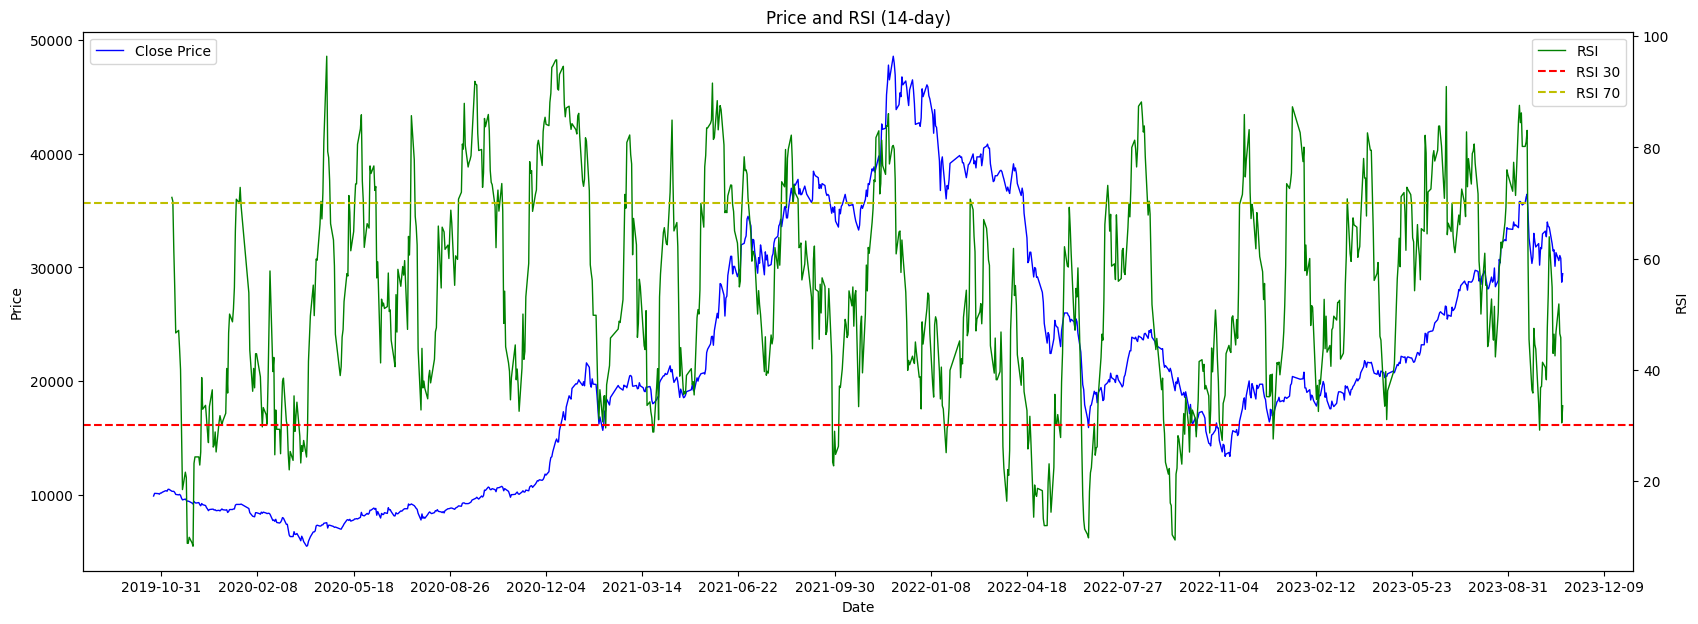

In [243]:
# Calculate RSI (Relative Strength Index)
def calculate_rsi(data, n):
    delta = data['close'].diff()  # Calculate price differences
    gain = delta.where(delta > 0, 0)  # Positive price differences
    loss = -delta.where(delta < 0, 0)  # Negative price differences
    
    avg_gain = gain.rolling(n).mean()  # Calculate average gain over 'n' periods
    avg_loss = loss.rolling(n).mean()  # Calculate average loss over 'n' periods
    
    rs = avg_gain / avg_loss  # Calculate Relative Strength (RS)
    rsi = 100 - (100 / (1 + rs))  # Calculate RSI
    
    return rsi

# Read data
data.sort_values(by='time', inplace=True)

# Calculate RSI with a period of 'n' (usually 14)
n = 14
data['rsi'] = calculate_rsi(data, n)

# Create the plot
fig, ax1 = plt.subplots(figsize=(20, 7))
plt.title(f'Price and RSI ({n}-day)')
plt.xlabel('Date')

# Price chart
ax1.set_ylabel('Price')
ax1.plot(data['time'], data['close'], 'b', lw=1, label='Close Price')
ax1.xaxis.set_major_locator(ticker.MaxNLocator(17))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# RSI chart
ax2 = ax1.twinx()
ax2.set_ylabel('RSI')
ax2.plot(data['time'], data['rsi'], 'g', lw=1, label='RSI')

# Add significant RSI thresholds (30 and 70)
ax2.axhline(y=30, color='r', linestyle='--', label='RSI 30')
ax2.axhline(y=70, color='y', linestyle='--', label='RSI 70')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


MACD

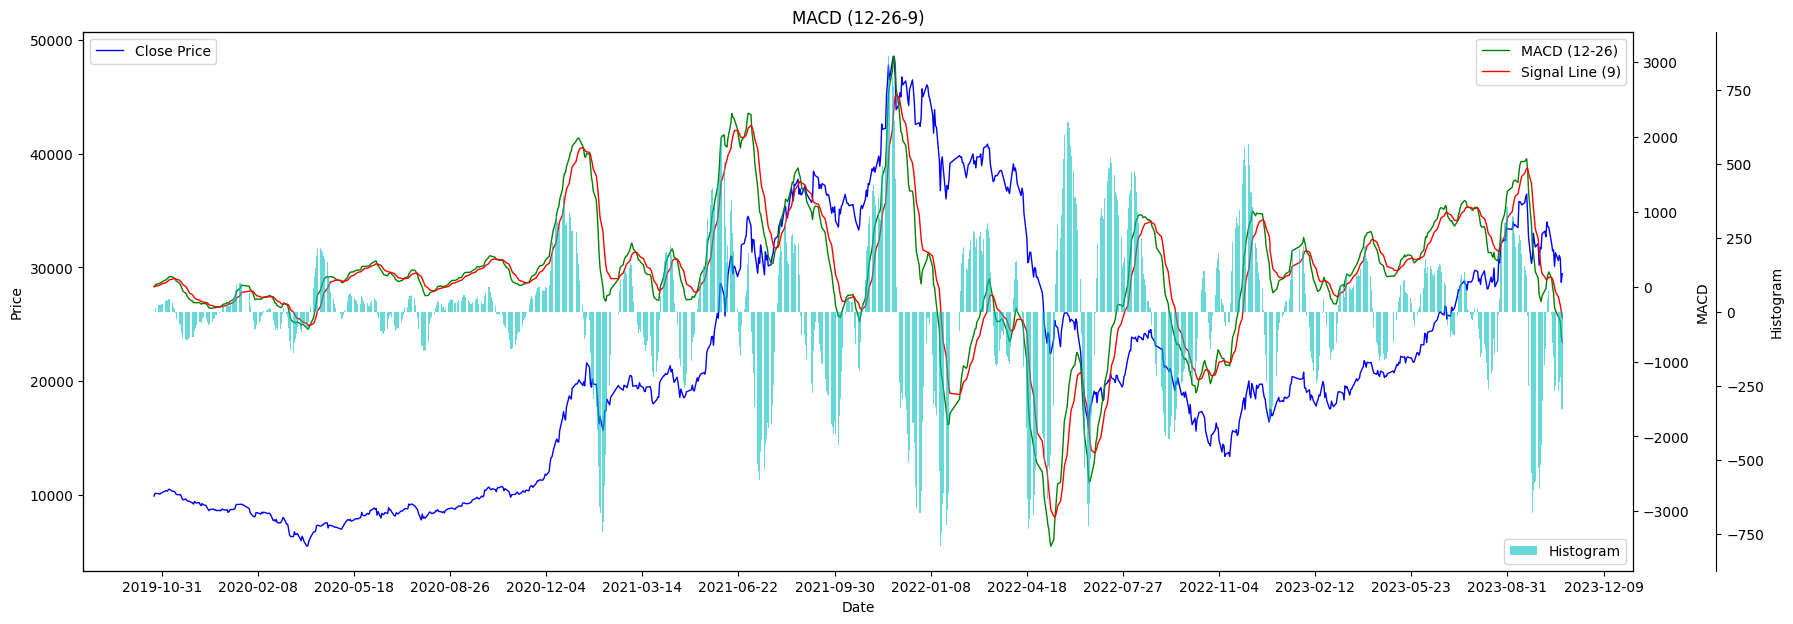

In [244]:
# Calculate Exponential Moving Average (EMA)
def calculate_ema(data, ndays):
    return data['close'].ewm(span=ndays, adjust=False).mean()

# Calculate MACD (Moving Average Convergence Divergence)
def calculate_macd(data, short_window, long_window, signal_window):
    short_ema = calculate_ema(data, short_window)
    long_ema = calculate_ema(data, long_window)
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

# Read data
data.sort_values(by='time', inplace=True)

# Parameters for MACD
short_window = 12  # Short period
long_window = 26   # Long period
signal_window = 9  # Signal period

# Calculate MACD and related lines
macd, signal_line, histogram = calculate_macd(data, short_window, long_window, signal_window)

# Thêm cột macd vào bảng data
data['macd'] = macd

# Create the plot
fig, ax1 = plt.subplots(figsize=(20, 7))
plt.title(f'MACD ({short_window}-{long_window}-{signal_window})')
plt.xlabel('Date')

# Price chart
ax1.set_ylabel('Price')
ax1.plot(data['time'], data['close'], 'b', lw=1, label='Close Price')
ax1.xaxis.set_major_locator(ticker.MaxNLocator(17))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# MACD and Signal Line chart
ax2 = ax1.twinx()
ax2.set_ylabel('MACD')
ax2.plot(data['time'], data['macd'], 'g', lw=1, label=f'MACD ({short_window}-{long_window})')
ax2.plot(data['time'], signal_line, 'r', lw=1, label=f'Signal Line ({signal_window})')

# Histogram chart
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel('Histogram')
ax3.bar(data['time'], histogram, width=1, color='c', alpha=0.6, label='Histogram')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='lower right')

# Show the plot
plt.show()


Bollinger Band

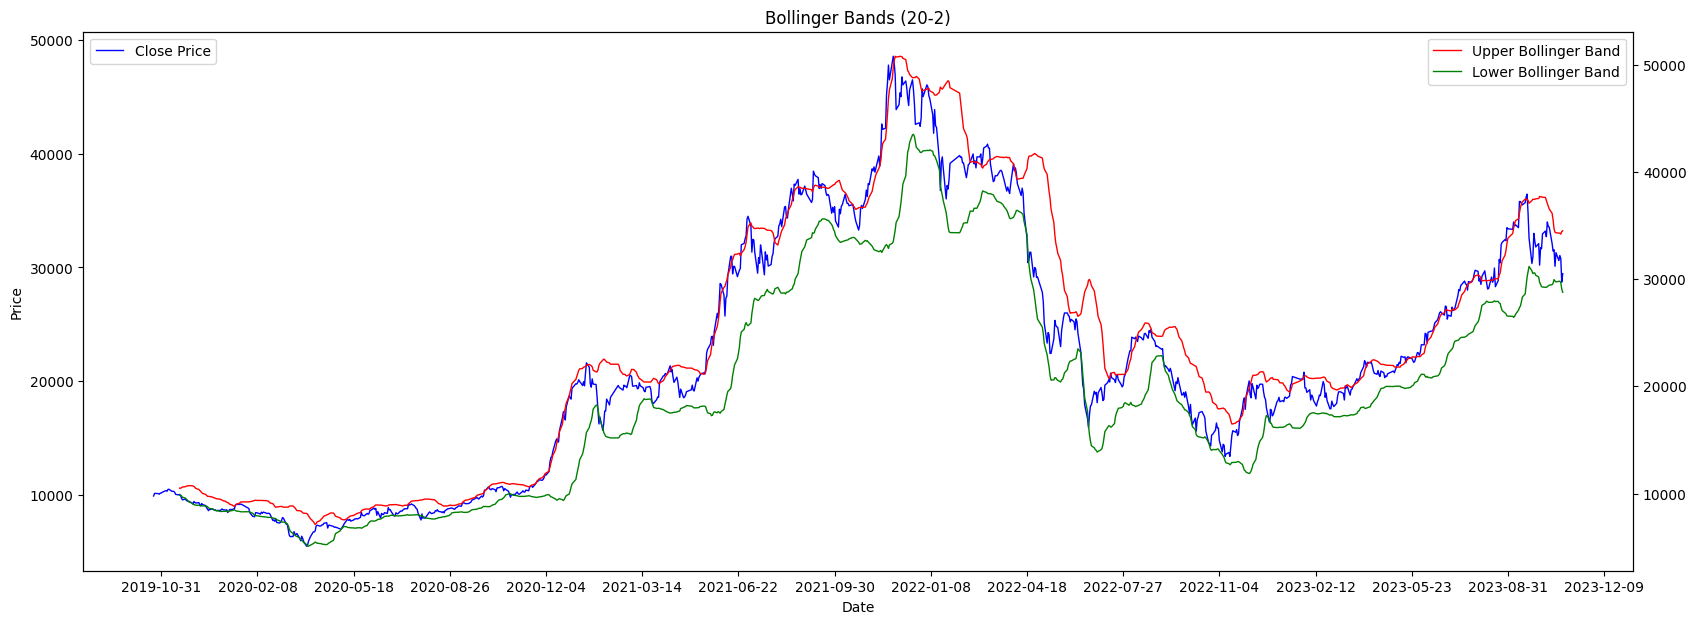

In [245]:
# Read data
data.sort_values(by='time', inplace=True)

# Define the parameters for Bollinger Bands
window = 20  # Window size for moving average
num_std_dev = 2  # Number of standard deviations for the bands

# Calculate the rolling mean (SMA) and standard deviation
data['SMA'] = data['close'].rolling(window=window).mean()
data['std'] = data['close'].rolling(window=window).std()

# Calculate the upper and lower Bollinger Bands
data['upper_band'] = data['SMA'] + (data['std'] * num_std_dev)
data['lower_band'] = data['SMA'] - (data['std'] * num_std_dev)

# Create the plot
fig, ax1 = plt.subplots(figsize=(20, 7))
plt.title(f'Bollinger Bands ({window}-{num_std_dev})')
plt.xlabel('Date')

# Price chart
ax1.set_ylabel('Price')
ax1.plot(data['time'], data['close'], 'b', lw=1, label='Close Price')
ax1.xaxis.set_major_locator(ticker.MaxNLocator(17))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Bollinger Bands chart
ax2 = ax1.twinx()
ax2.plot(data['time'], data['upper_band'], 'r', lw=1, label='Upper Bollinger Band')
ax2.plot(data['time'], data['lower_band'], 'g', lw=1, label='Lower Bollinger Band')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

RS

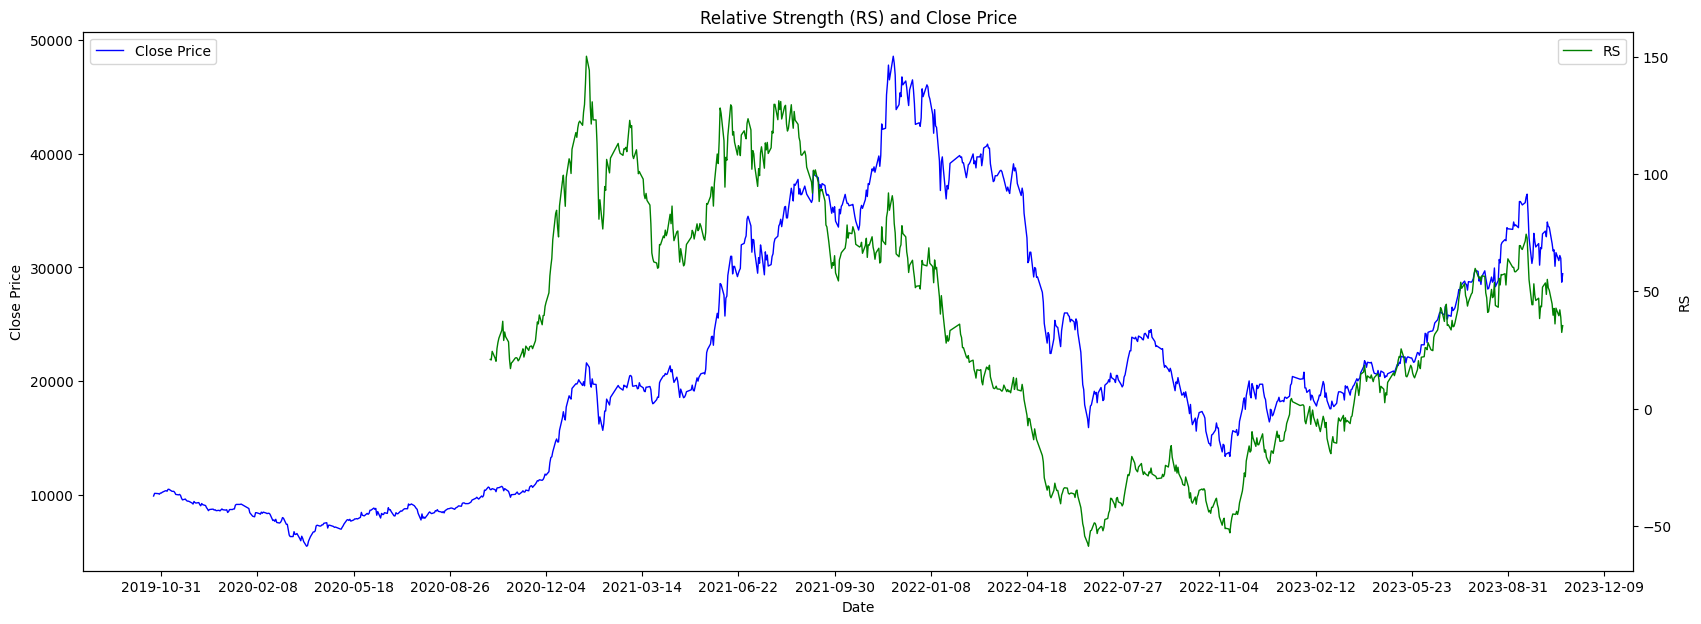

In [246]:
data.sort_values(by='time', inplace=True)

# Define the time periods (n1, n2, n3, n4) corresponding to 12 weeks, 24 weeks, 36 weeks, and 48 weeks
n1 = 12*5
data['delta_price_n1'] = data['close'].pct_change(periods=n1) * 100

n2 = 24*5
data['delta_price_n2'] = data['close'].pct_change(periods=n2) * 100

n3 = 36*5
data['delta_price_n3'] = data['close'].pct_change(periods=n3) * 100

n4 = 48*5
data['delta_price_n4'] = data['close'].pct_change(periods=n4) * 100

# Calculate RS using the provided formula
data['RS'] = (
    0.4 * data['delta_price_n1'] +
    0.3 * data['delta_price_n2'] +
    0.2 * data['delta_price_n3'] +
    0.1 * data['delta_price_n4']
)

# Create a figure for the plot
fig, ax1 = plt.subplots(figsize=(20, 7))
plt.title('Relative Strength (RS) and Close Price')
plt.xlabel('Date')

# Plot the Close Price on the left axis
ax1.set_ylabel('Close Price')
ax1.plot(data['time'], data['close'], 'b', lw=1, label='Close Price')
ax1.xaxis.set_major_locator(ticker.MaxNLocator(17))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Create a right axis for RS and plot it
ax2 = ax1.twinx()
ax2.set_ylabel('RS')
ax2.plot(data['time'], data['RS'], 'g', lw=1, label='RS')

# Add legends to the plot
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [251]:
try:
    data = data.drop('SMA', axis=1)
    data = data.drop('std', axis=1)
    data = data.drop('delta_price_n1', axis=1)
    data = data.drop('delta_price_n2', axis=1)
    data = data.drop('delta_price_n3', axis=1)
    data = data.drop('delta_price_n4', axis=1)
except Exception as e:
    print()

In [253]:
data.to_csv('ticker_data_with_TI.csv', index=False)